In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import VGG16
from tensorflow.keras import Model, layers
import glob
import cv2
from PIL import Image as Image2
from keras.applications.vgg16 import preprocess_input


folder_drive = "/content/drive/My Drive/Colab Notebooks/"
dataset_folder = "/content/drive/My Drive/Colab Notebooks/Flickr_Data/"

Using TensorFlow backend.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


PREPROCESSING

In [3]:
#images folder datapath
images = dataset_folder + 'Images/'

In [4]:
# list which containing all the images names
img = glob.glob(images+'*.jpg')
img = glob.glob(images+'*.jpg')
print(img[:5])

['/content/drive/My Drive/Colab Notebooks/Flickr_Data/Images/407569668_19b3f8eaf6.jpg', '/content/drive/My Drive/Colab Notebooks/Flickr_Data/Images/404702274_fa8b3fe378.jpg', '/content/drive/My Drive/Colab Notebooks/Flickr_Data/Images/411175971_0fffd3b8c6.jpg', '/content/drive/My Drive/Colab Notebooks/Flickr_Data/Images/396763804_3b7f1e12a8.jpg', '/content/drive/My Drive/Colab Notebooks/Flickr_Data/Images/406248253_27b5eba25a.jpg']


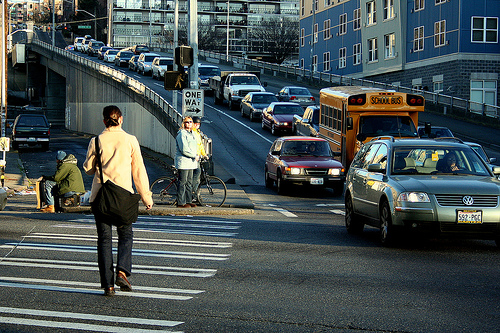

In [5]:
testing_img_path = img[6]
Image2.open(testing_img_path)

In [6]:
# prepare the image for the VGG model
def preprocess(image_path):
  x = image.load_img(image_path, target_size=(224, 224))
  x = image.img_to_array(x)
  x = np.expand_dims(x, axis=0)
  x = preprocess_input(x)
  return x
def image_to_array(image_path):
  x = image.load_img(testing_img_path)
  x = image.img_to_array(x)
  return x

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


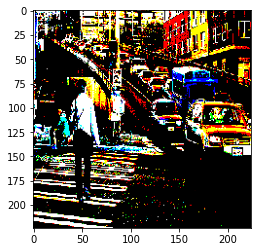

In [7]:
plt.imshow(np.squeeze(preprocess(testing_img_path)))
image.save_img("prueba.png",np.squeeze(preprocess(testing_img_path)))

CREATION OF THE MODEL

In [8]:
pre_model = VGG16()

553467904/553467096 [==============================] - 6s 0us/step


In [9]:
#removing the last softmax layer
new_input = pre_model.input
hidden_layer = pre_model.layers[-2].output

model = Model(new_input, hidden_layer)

In [10]:
units_num = 224*224*3
#Creating new layers added at the beginning of VGG16
dense = layers.Dense(units_num, use_bias = False)
reshaper = layers.Reshape((224, 224, 3), input_shape=(units_num,))
#Adding new layers
final_input = layers.Input(shape=(1,))
x = dense(final_input)
x = reshaper(x)
#Adding layers from VGG16 except from the input one
for layer in model.layers[1:]:
  x = layer(x)
final_model = Model(final_input,x)
#freeze all parameter except for Dense one containing pixels of the image as weights
for layer in final_model.layers[2:]:
  layer.trainable = False
final_model.summary()


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
dense (Dense)                (None, 150528)            150528    
_________________________________________________________________
reshape (Reshape)            (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     7385

In [11]:
#Create a dictionary with all real y for every image?? A LOT OF IMAGES JEJE
#??????

In [12]:
final_model.compile(loss="mse", optimizer="adam", metrics=['accuracy'])

In [13]:
image_layer = final_model.layers[1]
image_testing = preprocess(testing_img_path)
print(image_testing.shape)
image_testing = np.squeeze(image_testing)
print(image_testing.shape)
image_testing = image_testing.reshape((units_num,))
print(image_testing.shape)

(1, 224, 224, 3)
(224, 224, 3)
(150528,)


In [14]:
#function adding noise to the image. Code from: https://stackoverflow.com/questions/22937589/how-to-add-noise-gaussian-salt-and-pepper-etc-to-image-in-python-with-opencv
def noisy(noise_typ, image): #image is a numpy array
  if noise_typ == "gauss":
      row,col,ch= image.shape
      mean = 0
      var = 0.1
      sigma = var**0.5
      gauss = np.random.normal(mean,sigma,(row,col,ch))
      gauss = gauss.reshape(row,col,ch)
      noisy = image + gauss
      return noisy
  elif noise_typ == "s&p":
      row,col,ch = image.shape
      s_vs_p = 0.5
      amount = 0.025
      out = np.copy(image)
      # Salt mode
      num_salt = np.ceil(amount * image.size * s_vs_p)
      coords = [np.random.randint(0, i - 1, int(num_salt))
              for i in image.shape]
      out[coords] = 1
      # Pepper mode
      num_pepper = np.ceil(amount* image.size * (1. - s_vs_p))
      coords = [np.random.randint(0, i - 1, int(num_pepper))
              for i in image.shape]
      out[coords] = 0
      return out
  elif noise_typ == "poisson":
      vals = len(np.unique(image))
      vals = 2 ** np.ceil(np.log2(vals))
      noisy = np.random.poisson(image * vals) / float(vals)
      return noisy
  elif noise_typ =="speckle":
      row,col,ch = image.shape
      gauss = np.random.randn(row,col,ch)
      gauss = gauss.reshape(row,col,ch)        
      noisy = image + image * gauss
      return noisy

In [15]:
noisy_img = noisy("s&p",image_to_array(testing_img_path))
image.save_img(folder_drive + "edit_photos/380590140_25b9889772_s&p.jpg", noisy_img)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


In [16]:
def recover_image(image_path,modified_image_path):
  input = np.array([1]) #always this one

  #Encoding of unmodified photo
  image = preprocess(image_path)
  image_layer.set_weights([np.reshape(np.squeeze(image),(1,units_num))])
  h_real = final_model.predict(input)

  mod_image = preprocess(modified_image_path)
  image_layer.set_weights([np.reshape(np.squeeze(mod_image),(1,units_num))])
  final_model.fit(input,h_real)
  plt.imshow(np.reshape(np.squeeze(np.array(image_layer.get_weights())),(224,224,3)))

In [17]:
print(testing_img_path)

/content/drive/My Drive/Colab Notebooks/Flickr_Data/Images/380590140_25b9889772.jpg


In [18]:
testing_img_path_edit = folder_drive + "edit_photos/380590140_25b9889772_s&p.jpg"

1/1 [==============================] - 0s 1ms/step - loss: 0.2300 - accuracy: 0.0000e+00


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


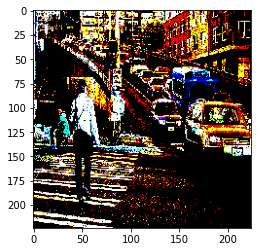

In [19]:
recover_image(testing_img_path,testing_img_path_edit)